In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_abs_diff_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_dense_512_128_32_8_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_max_pool_64_32_16_8_stride_4_B1H_Inst_center_scale_10

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_65_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_65_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_65_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"],
                                  return_meta=True)
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"],
                                       return_meta=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           960       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

May/03 17:25:38 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
May/03 17:25:38 pyobsbox.generator INFO: ts_length: 63488
May/03 17:25:38 pyobsbox.generator INFO: shuffle: True
May/03 17:25:38 pyobsbox.generator INFO: seed: 42
May/03 17:25:38 pyobsbox.generator INFO: batch_size: 7936
May/03 17:25:38 pyobsbox.generator INFO: sequence_length: 2048
May/03 17:25:38 pyobsbox.generator INFO: n_bunches: 256
May/03 17:25:38 pyobsbox.generator INFO: __len__: 550
May/03 17:25:38 pyobsbox.generator INFO: fetched_log_folder: None
May/03 17:25:38 pyobsbox.generator INFO: fetched_log_prefix: 
May/03 17:25:38 pyobsbox.generator INFO: normalization: min_max
May/03 17:25:38 pyobsbox.generator INFO: normalization_pre_split: False
May/03 17:25:38 pyobsbox.generator INFO: normalization_kwargs: {}
May/03 17:25:38 pyobsbox.generator INFO: abs_diff: False
May/03 17:25:38 pyobsbox.generator INFO: diff: False
May/03 17:25:38 pyobsbox

In [9]:
print(train_metadata.shape)
train_metadata.head()

(140800, 11)


type  fill  beam plane  q           date_time  \
7246092  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889420  Inst  7453     1     h  7 2018-11-18 06:39:21   
1617606  Inst  6663     1     h  7 2018-05-10 15:13:15   
6142326  Inst  6953     1     h  7 2018-07-21 06:32:07   
593874   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7246092  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889420  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/...        480   
1617606  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6142326  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593874   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7246092        389.0         257.0      65536  
6889420       1506.0         278.0      65536  
1617606       1627.0        1195.0      65536  
6142326        770.0         544.0      65536  
593874        2698.0        1481.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(1280, 11)


type  fill  beam plane  q           date_time  \
9053212  Inst  7135     1     h  7 2018-09-07 19:52:14   
898047   Inst  7365     1     h  7 2018-10-27 00:16:40   
9534741  Inst  7315     1     h  7 2018-10-18 21:37:14   
7282472  Inst  6348     1     h  7 2017-10-30 23:23:14   
8246962  Inst  6681     1     h  7 2018-05-14 06:32:31   

                                                      file  n_bunches  \
9053212  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/...       2556   
898047   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7365/...        852   
9534741  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7315/...       2556   
7282472  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/...       1868   
8246962  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6681/...        540   

         bunch_index  bunch_number  ts_length  
9053212        786.0         560.0      65536  
898047         699.0         344.0      65536  
9534741       1278.0         924.0      65536  
7282472       2548.0        1387.0      65536  
8246962        468.0         310.0      65536

# Loss functions

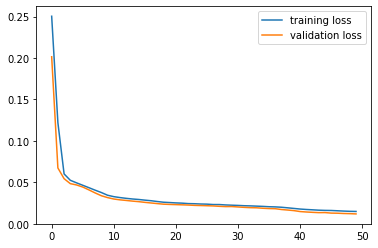

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
temp_train = [train_generator[i] for i in tqdm(range(50))]
train_dataset = np.vstack([data[0] for data in temp_train])
train_dataset.shape

bunch_sorted_index: [1 2 0]
group_bunches: [2882.  607. 1787.]
group_bunches sorted: [ 607. 1787. 2882.]
restore_index: [2 0 1]
group_bunches restored: [2882.  607. 1787.]
bunch_sorted_index: [0 2 1]
group_bunches: [ 327. 2469. 1538.]
group_bunches sorted: [ 327. 1538. 2469.]
restore_index: [0 2 1]
group_bunches restored: [ 327. 2469. 1538.]



(396800, 2048, 2)

In [13]:
train_dataset_meta = pd.concat([meta[1] for meta in temp_train])
train_dataset_meta.shape

(396800, 12)

In [14]:
del temp_train

In [15]:
temp_validation = [validation_generator[i] for i in tqdm(range(5))]
validation_dataset = np.vstack([data[0] for data in temp_validation])
validation_dataset.shape

(39680, 2048, 2)

In [16]:
validation_dataset_meta = pd.concat([meta[1] for meta in temp_validation])
validation_dataset_meta.shape

(39680, 12)

In [17]:
del temp_validation

# Predictions

In [18]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 91s 2s/step


(396800, 2048, 2)

In [19]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 6s 1s/step


(39680, 2048, 2)

In [47]:
MAE_train = abs(train_pred - train_dataset).mean(axis=(1, 2)).squeeze()
MAE_train.shape

(396800,)

In [48]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=(1, 2)).squeeze()
MAE_validation.shape

(39680,)

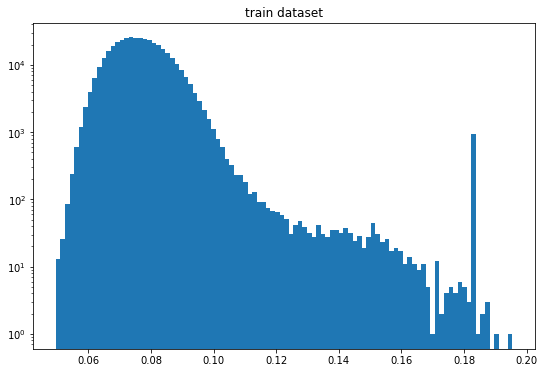

In [49]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [50]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.07291800506179588

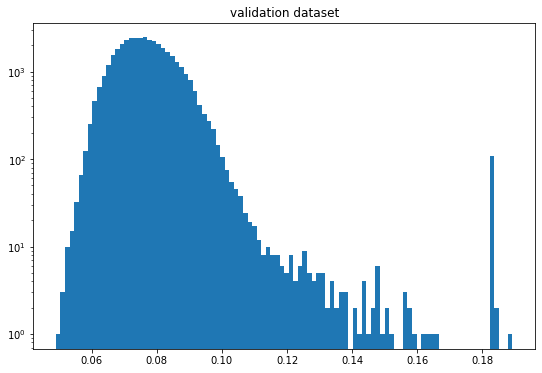

In [51]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [55]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.07564007649021412

In [26]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [27]:
max_MAE_indices

array([308249, 111200, 205509, ..., 101703, 340766, 298674])

In [28]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal[:, 0])
    axes[0].plot(pred_signal[:, 0])

    axes[1].plot(true_signal[:, 1])
    axes[1].plot(pred_signal[:, 1])
#     axes[1].plot(np.abs(np.diff(true_signal)))
#     axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

from pathlib import Path
from pyobsbox.utils import H5_PLANE_KEY
from pyobsbox import DB
import h5py

db = DB()

def load_plot(filepath: str, bunch_index: int):
    
    file_data = db._extract_columns(filepath)
    beam_key = "B{}".format(file_data["beam"])
    plane_key = H5_PLANE_KEY[file_data["plane"]]
    with h5py.File(filepath, "r") as h5_file:
        ob_data = h5_file[beam_key][plane_key]
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(ob_data[:, bunch_index])

index:  308249
MAE:  0.19544626708364096
n_bunches       460
bunch_index     787
bunch_number    425
chunk             6
Name: 1657, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h15m33s.h5


(10240.0, 16384.0)

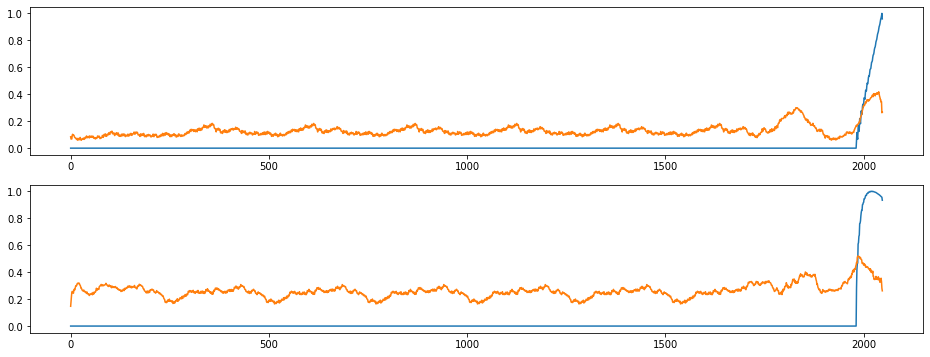

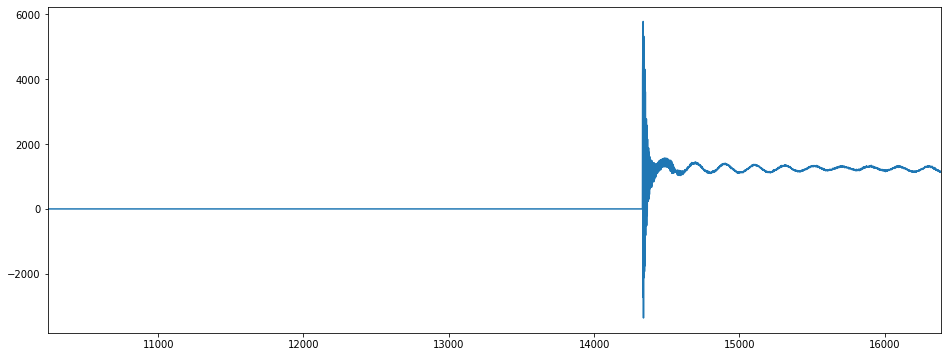

In [29]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_dataset_meta.iloc[anomalous_index]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal)
load_plot(metadata_row['file'], metadata_row['bunch_index'])

signal_chunk = metadata_row['chunk']
plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])

# Top rightmost signals

index:  308249
MAE:  0.19544626708364096
n_bunches       460
bunch_index     787
bunch_number    425
chunk             6
Name: 1657, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6192/instability_data/06192_Inst_B1H_Q7_20170912_17h15m33s.h5


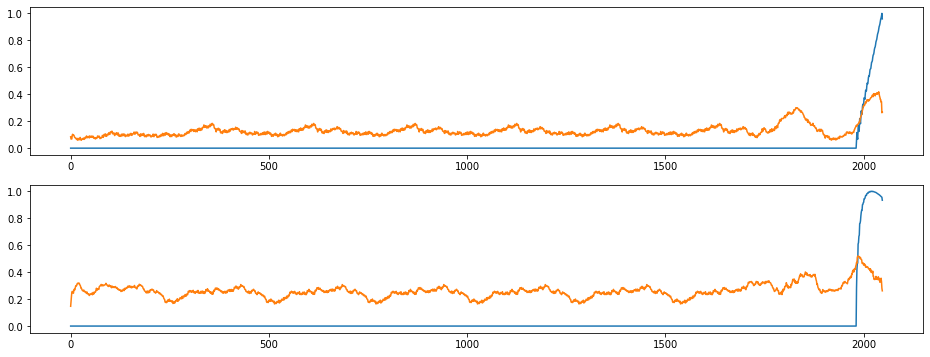

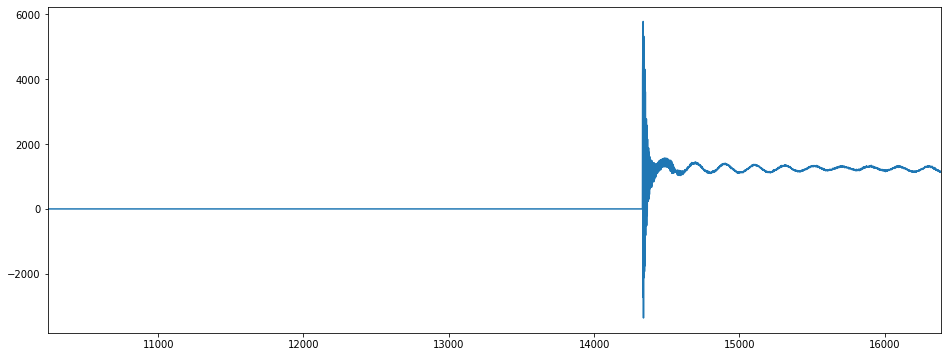

index:  111200
MAE:  0.19028676440317144
n_bunches       1308
bunch_index     1669
bunch_number    1221
chunk             15
Name: 3964, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6936/instability_data/06936_Inst_B1H_Q7_20180717_15h14m13s.h5


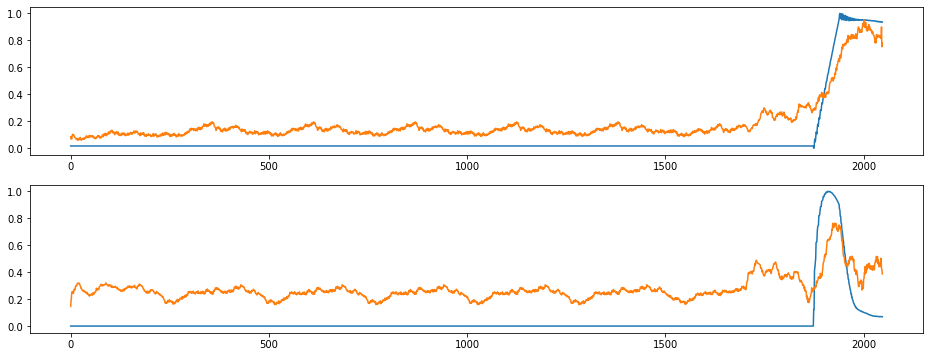

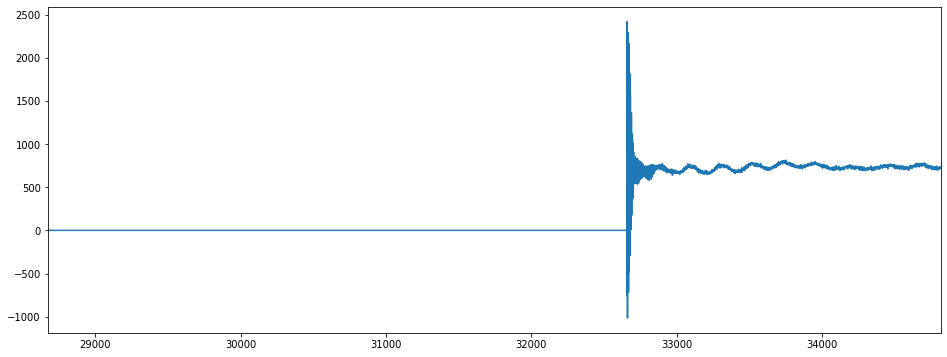

index:  205509
MAE:  0.18774824026963652
n_bunches       428
bunch_index     771
bunch_number    426
chunk             5
Name: 1448, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6413/instability_data/06413_Inst_B1H_Q7_20171123_19h28m39s.h5


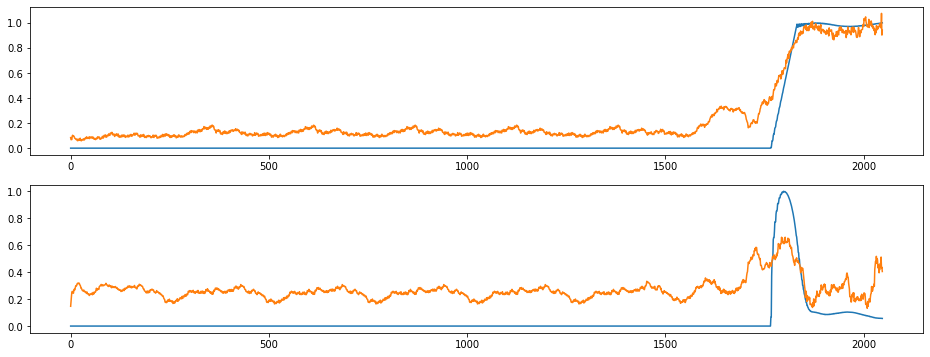

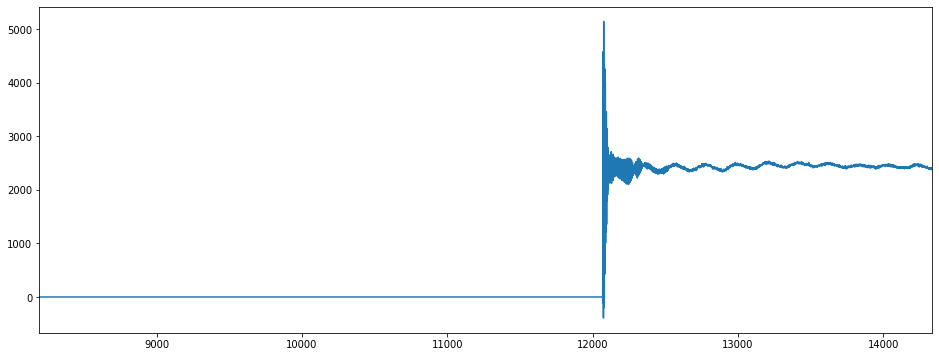

index:  261038
MAE:  0.18767624092070823
n_bunches       404
bunch_index     694
bunch_number    382
chunk             2
Name: 644, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/instability_data/06253_Inst_B1H_Q7_20170928_13h00m35s.h5


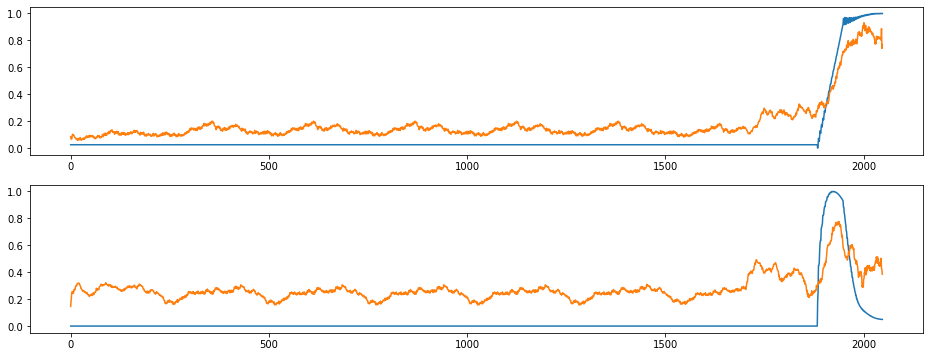

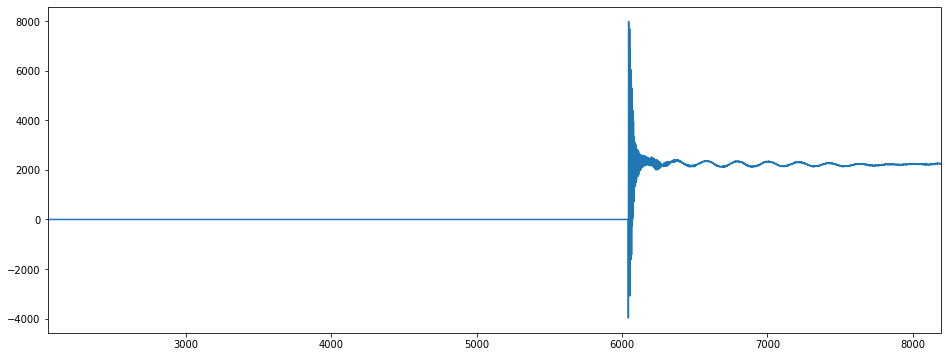

index:  364783
MAE:  0.18727695720935333
n_bunches       1292
bunch_index     2948
bunch_number    1269
chunk              1
Name: 363, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6397/instability_data/06397_Inst_B1H_Q7_20171118_13h08m15s.h5


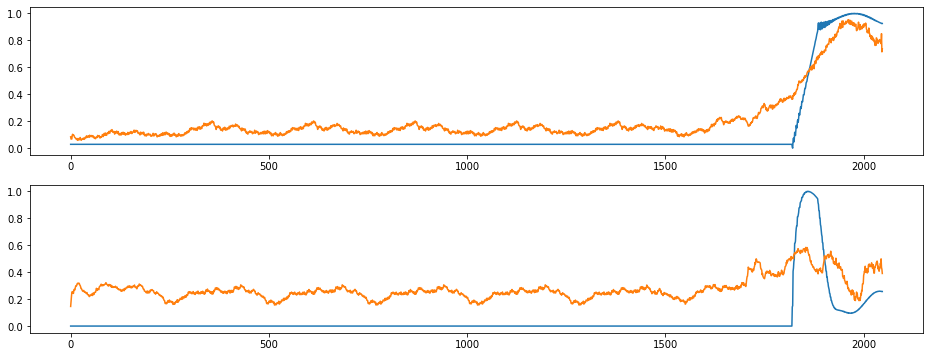

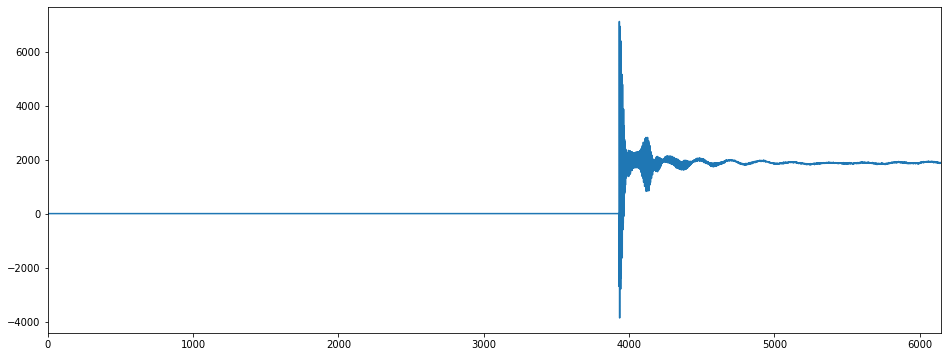

index:  362911
MAE:  0.18648573335035945
n_bunches        588
bunch_index     1216
bunch_number     507
chunk             19
Name: 5118, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_14h58m14s.h5


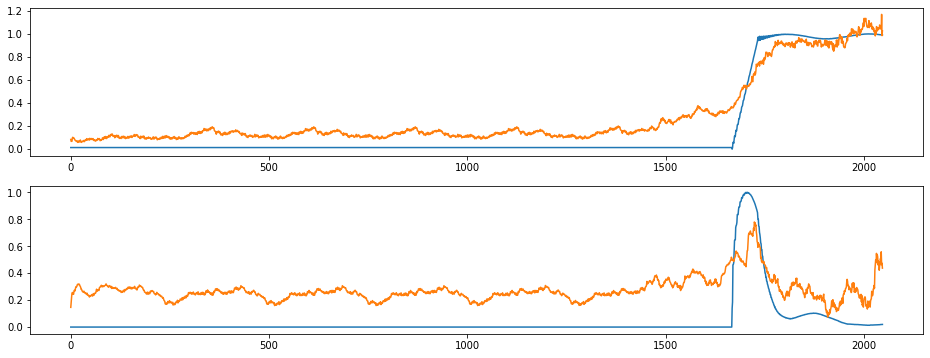

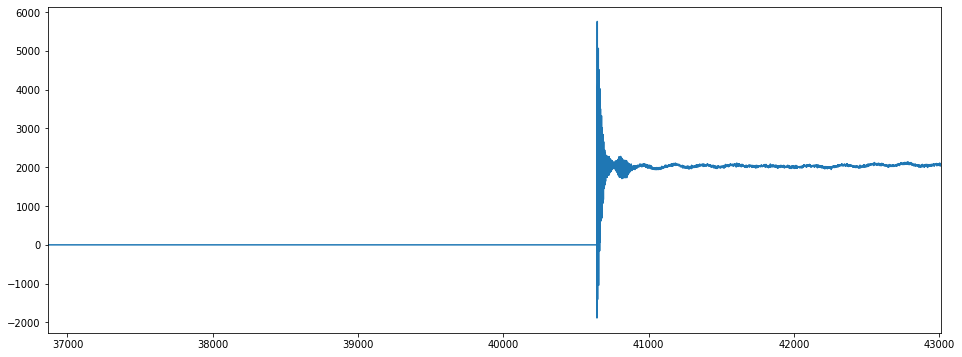

index:  86064
MAE:  0.1855783550181362
n_bunches       264
bunch_index      38
bunch_number      1
chunk            28
Name: 7327, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6680/instability_data/06680_Inst_B1H_Q7_20180514_06h11m14s.h5


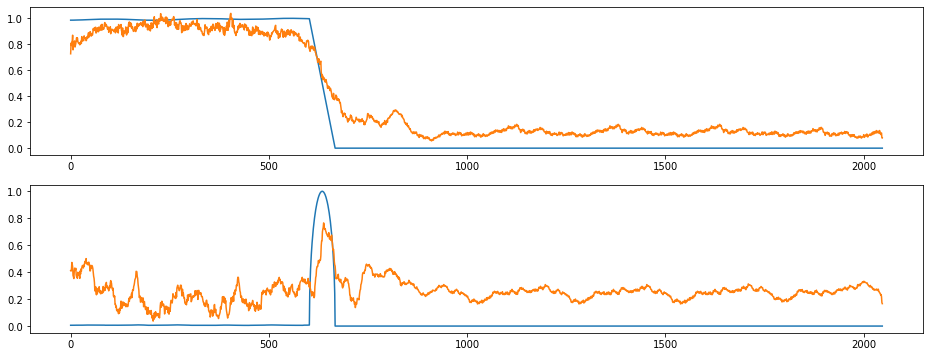

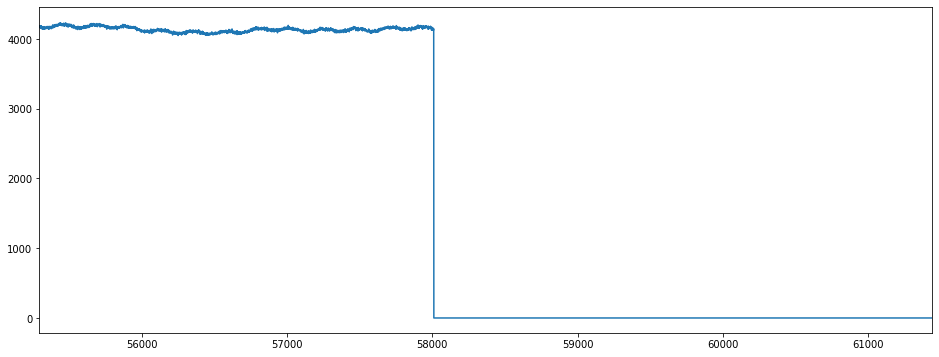

index:  375070
MAE:  0.18405150186378022
n_bunches       1740
bunch_index     3125
bunch_number    1663
chunk             17
Name: 4545, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6271/instability_data/06271_Inst_B1H_Q7_20171004_10h21m54s.h5


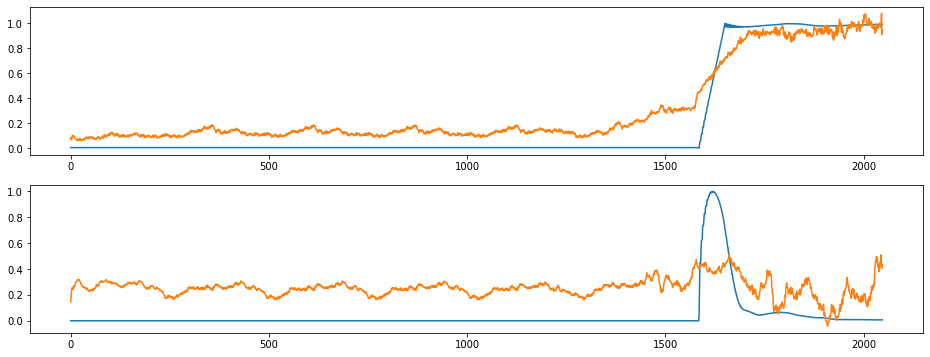

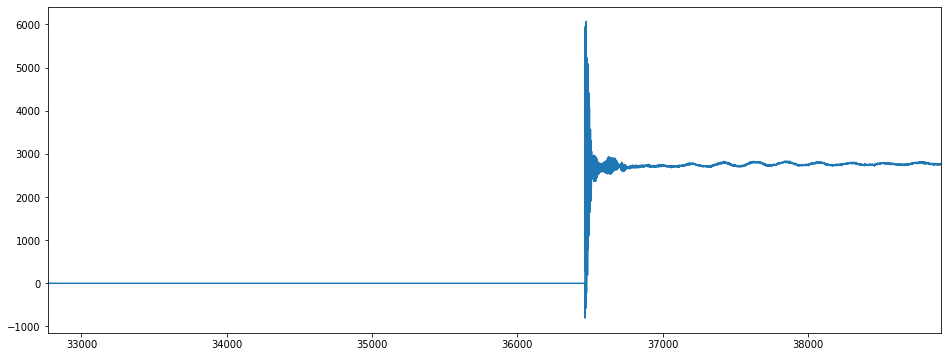

index:  53165
MAE:  0.18369732562552962
n_bunches       396
bunch_index     509
bunch_number    363
chunk            10
Name: 2597, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7331/instability_data/07331_Inst_B1H_Q7_20181022_14h58m45s.h5


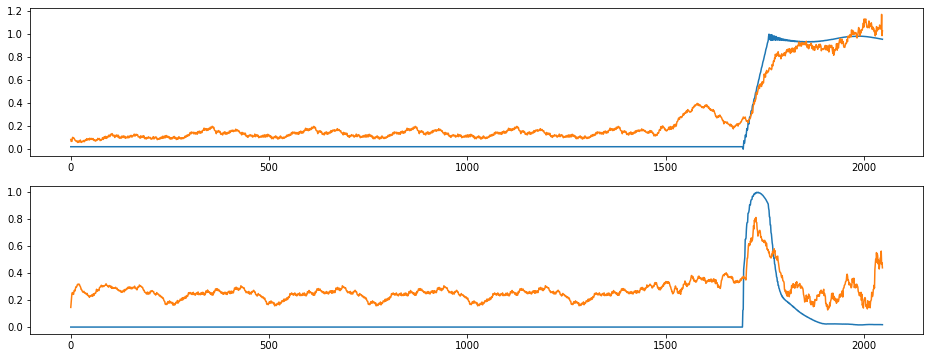

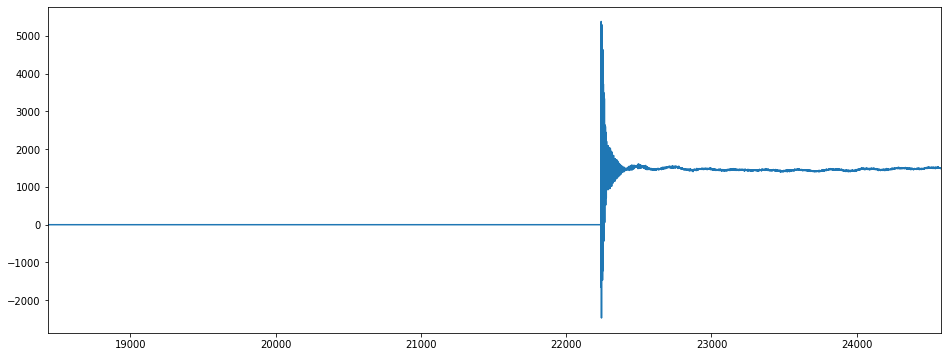

index:  361553
MAE:  0.18360896638375745
n_bunches        924
bunch_index     1112
bunch_number     803
chunk             10
Name: 2565, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7108/instability_data/07108_Inst_B1H_Q7_20180831_04h54m09s.h5


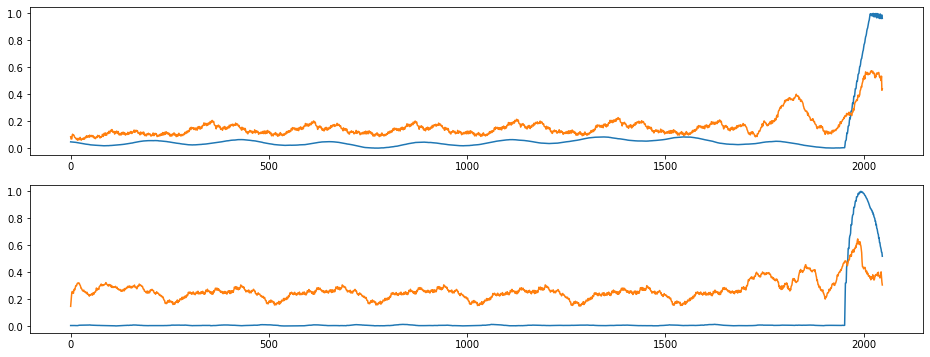

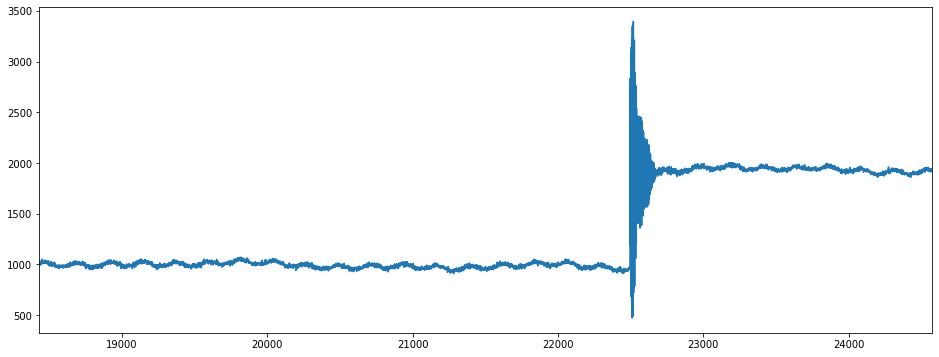

In [30]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Top leftmost signals

index:  298674
MAE:  0.04957928848620633
n_bunches       601
bunch_index     450
bunch_number    176
chunk            23
Name: 6076, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6854/instability_data/06854_Inst_B1H_Q7_20180627_21h40m15s.h5


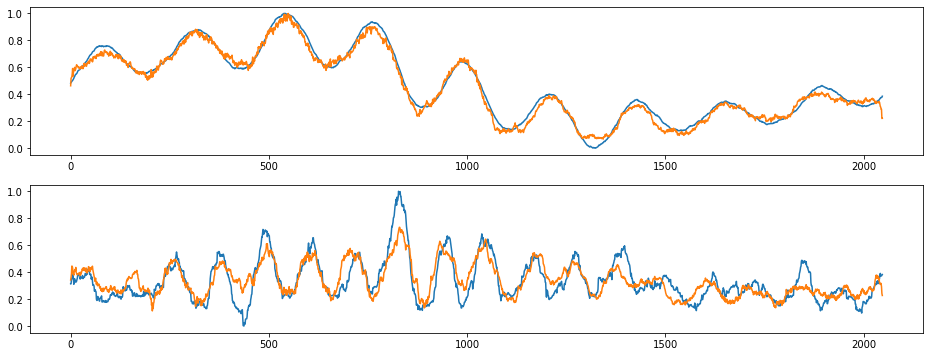

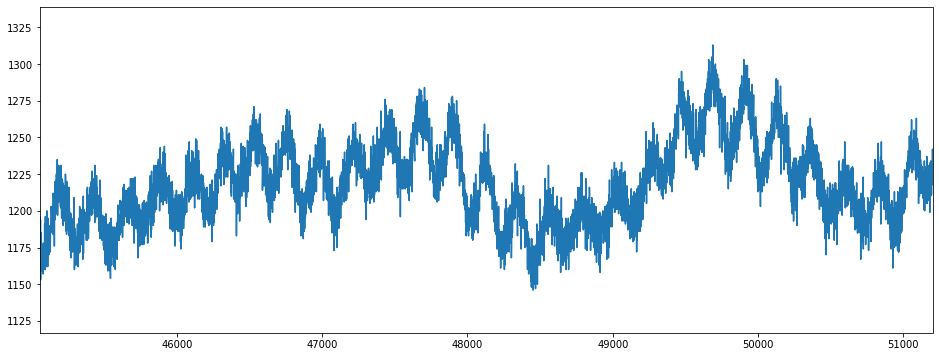

index:  340766
MAE:  0.04997346604370381
n_bunches       1868
bunch_index     3047
bunch_number    1633
chunk             14
Name: 3811, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_18h53m13s.h5


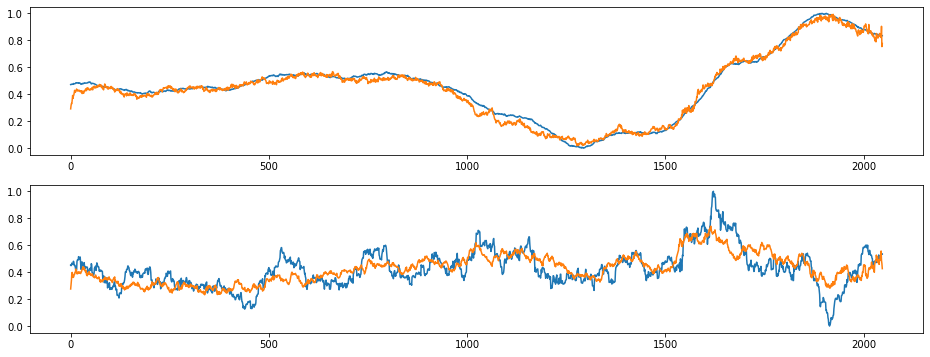

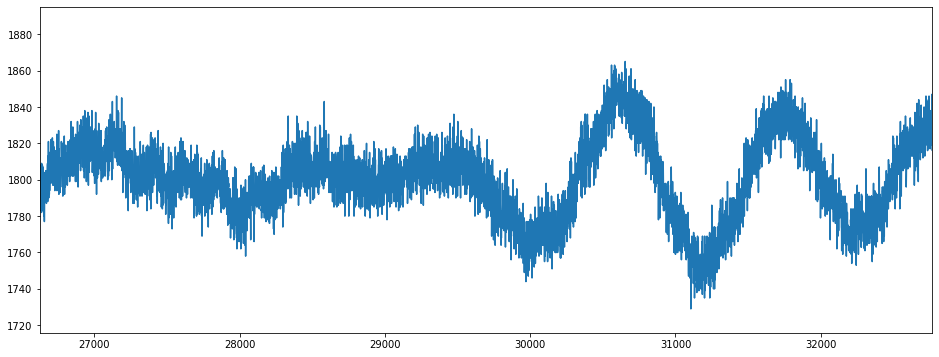

index:  101703
MAE:  0.05010274431326835
n_bunches       142
bunch_index     437
bunch_number     99
chunk            12
Name: 3141, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6984/instability_data/06984_Inst_B1H_Q7_20180726_20h27m14s.h5


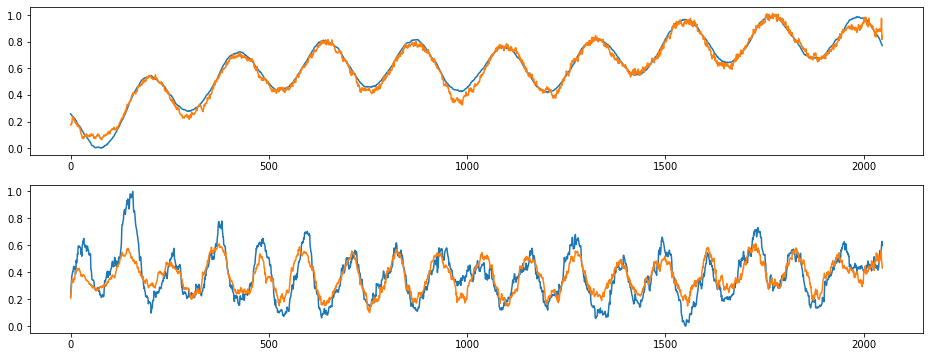

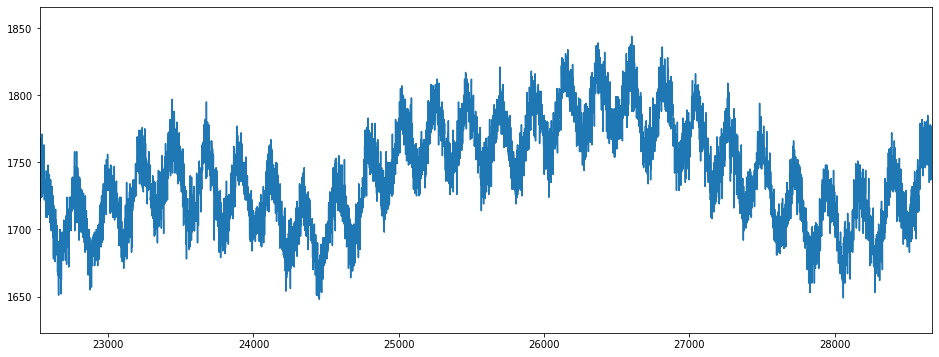

index:  76973
MAE:  0.05019036541397543
n_bunches       780
bunch_index     969
bunch_number    698
chunk            28
Name: 7302, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h32m49s.h5


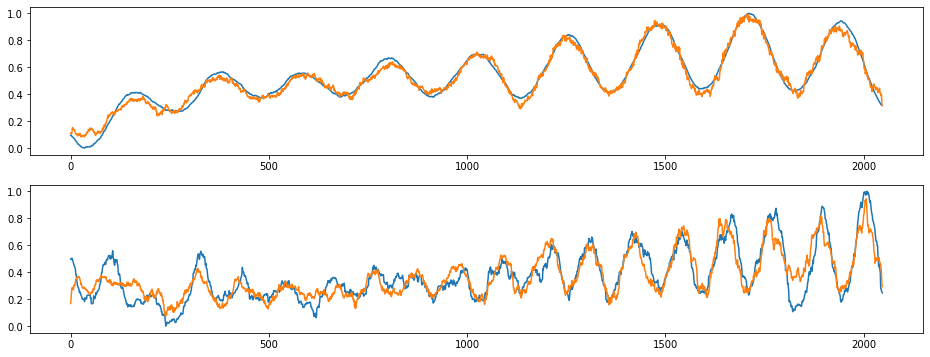

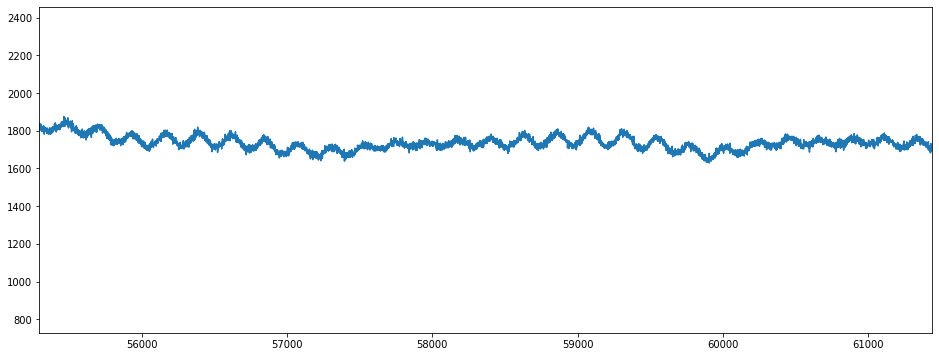

index:  125323
MAE:  0.050318801713379976
n_bunches       780
bunch_index     777
bunch_number    551
chunk            20
Name: 5294, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7112/instability_data/07112_Inst_B1H_Q7_20180901_12h07m40s.h5


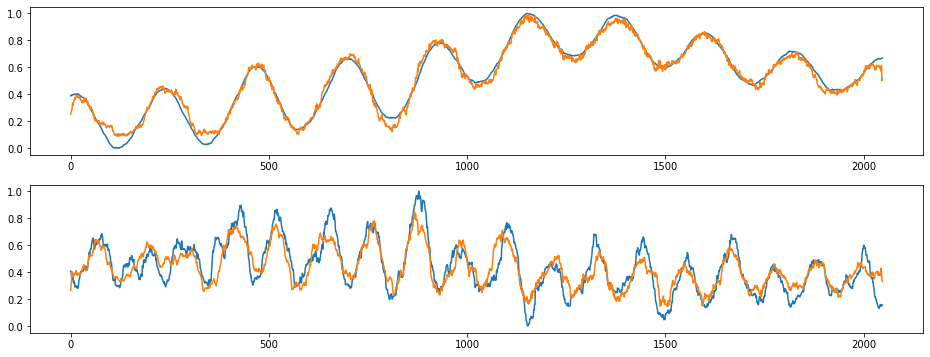

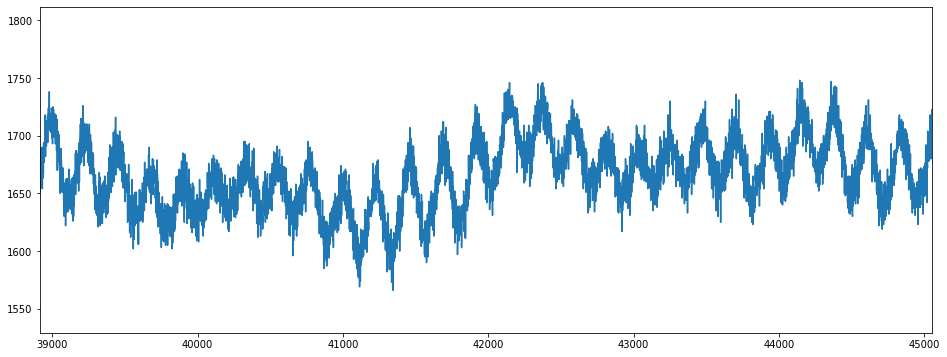

index:  245844
MAE:  0.05056368379111022
n_bunches        733
bunch_index     2222
bunch_number     467
chunk              3
Name: 814, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_09h40m32s.h5


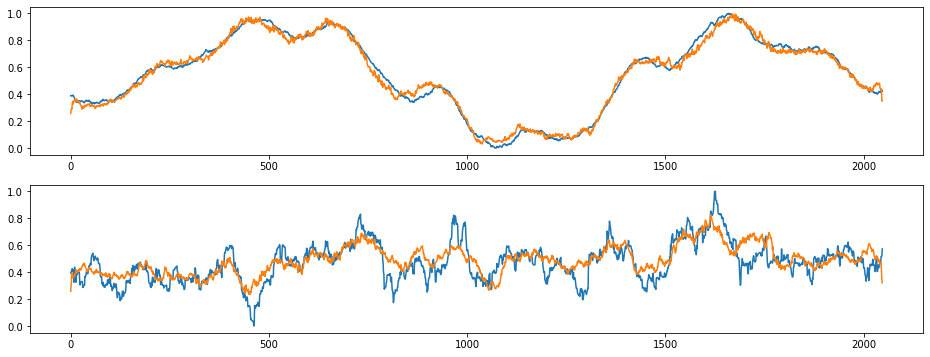

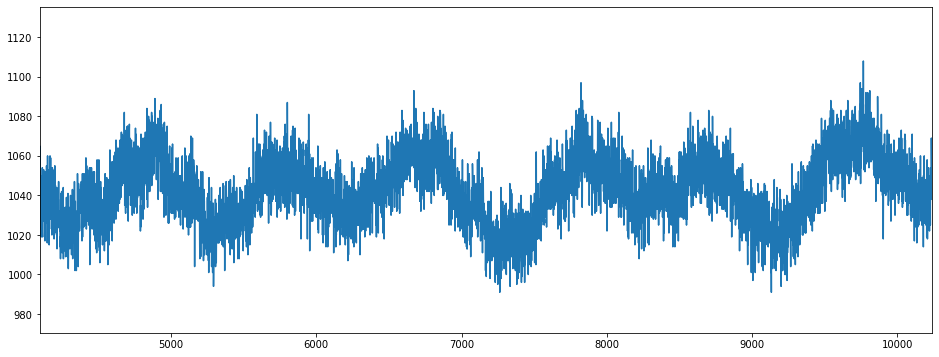

index:  166625
MAE:  0.050604577714807676
n_bunches       12
bunch_index      4
bunch_number     4
chunk           22
Name: 5752, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6603/instability_data/06603_Inst_B1H_Q7_20180423_19h41m08s.h5


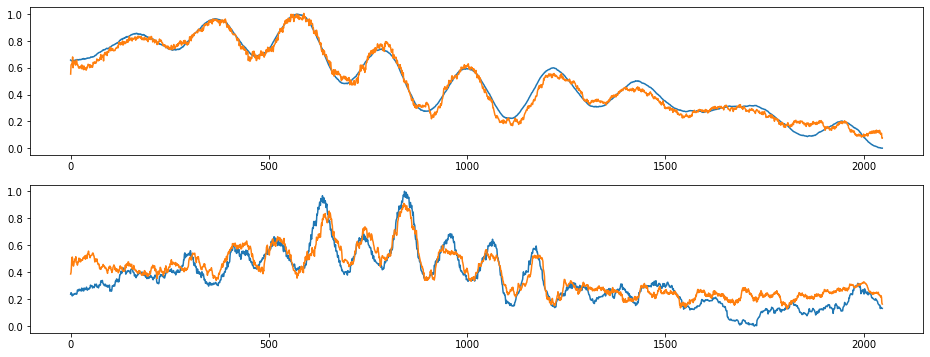

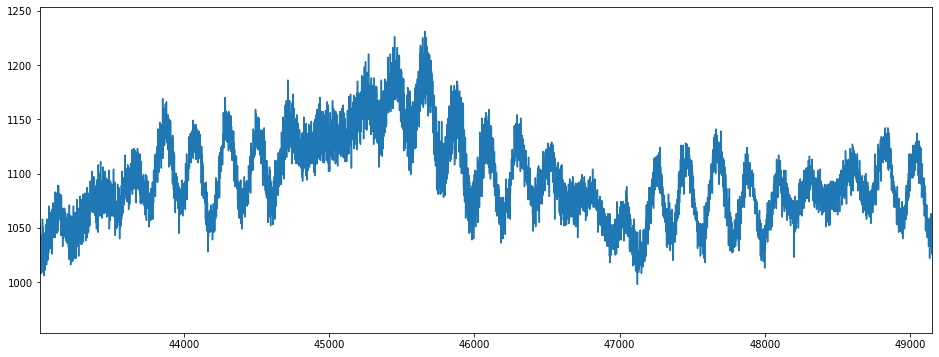

index:  57273
MAE:  0.05063526694990781
n_bunches        408
bunch_index     2194
bunch_number     343
chunk             27
Name: 7030, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_04h36m15s.h5


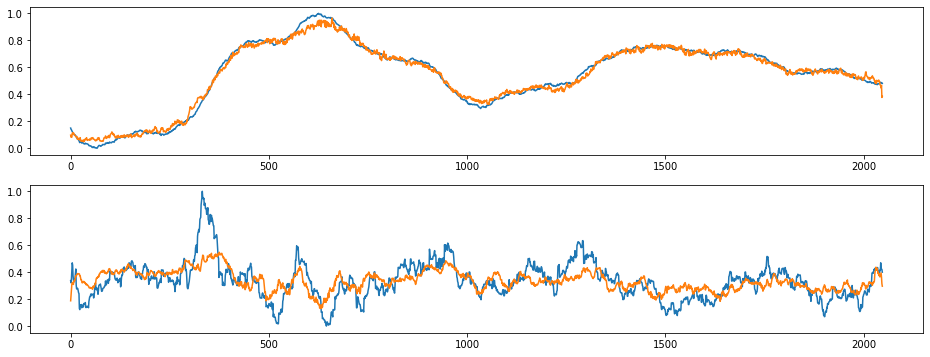

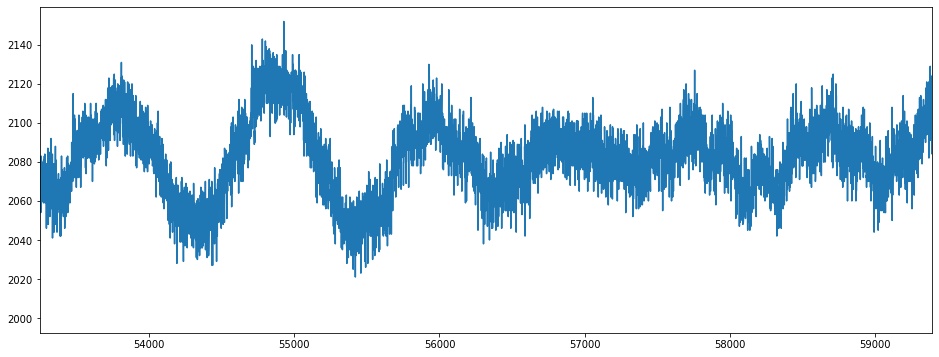

index:  127950
MAE:  0.050635832160379216
n_bunches       924
bunch_index     717
bunch_number    526
chunk            23
Name: 5943, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6786/instability_data/06786_Inst_B1H_Q7_20180613_15h31m01s.h5


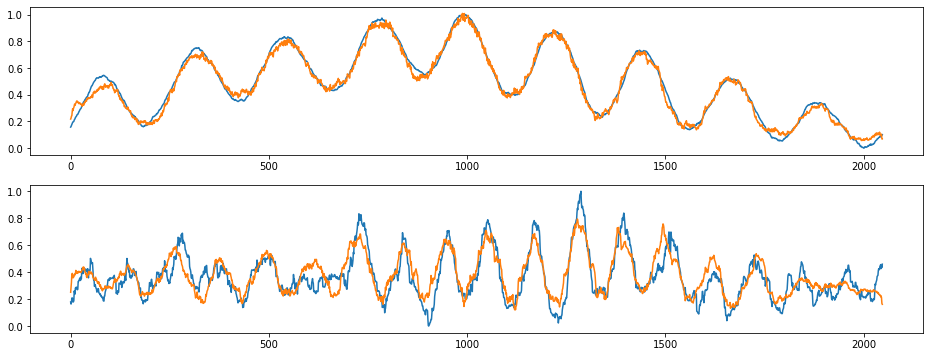

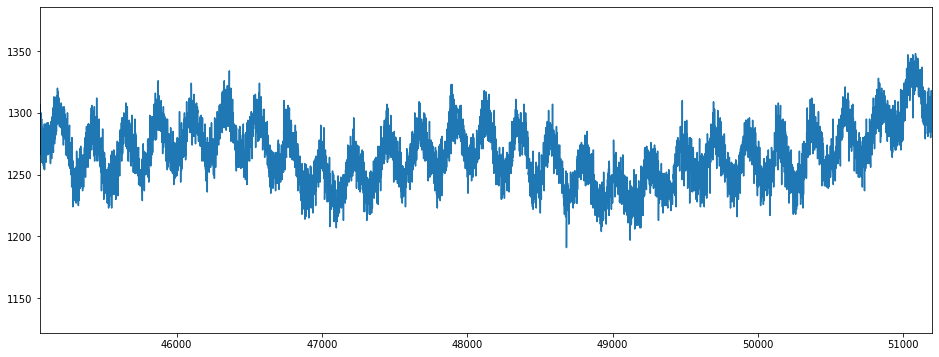

index:  181912
MAE:  0.0508065898432694
n_bunches       1868
bunch_index     2509
bunch_number    1360
chunk             13
Name: 3428, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6349/instability_data/06349_Inst_B1H_Q7_20171031_05h38m13s.h5


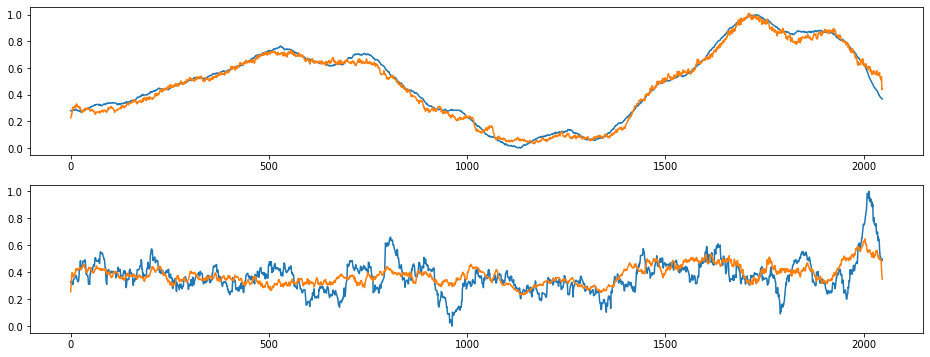

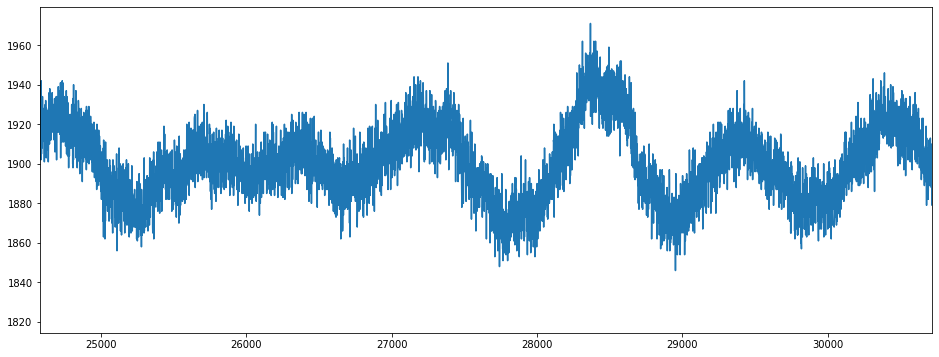

In [31]:
for i in range(1, 11):
    left_most = -i
    anomalous_index = max_MAE_indices[left_most]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Signals around the peak

In [32]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  147009
MAE:  0.07291802414550833
n_bunches        648
bunch_index     3244
bunch_number     610
chunk             12
Name: 3133, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7447/instability_data/07447_Inst_B1H_Q7_20181116_05h48m15s.h5


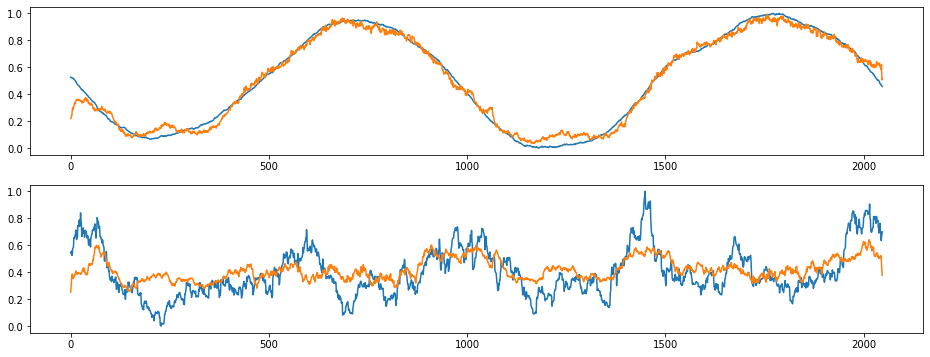

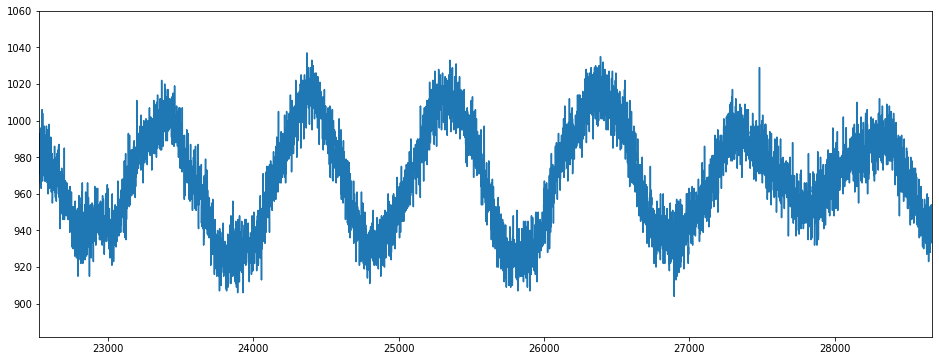

index:  125552
MAE:  0.07291803008944464
n_bunches       1868
bunch_index     2615
bunch_number    1390
chunk              7
Name: 2038, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_22h19m14s.h5


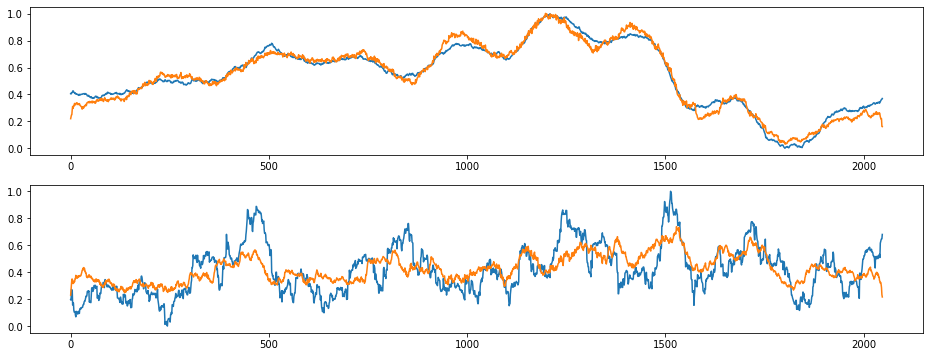

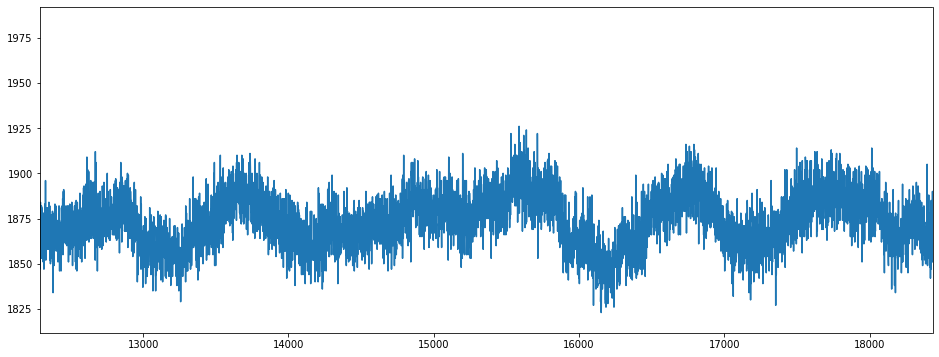

index:  155548
MAE:  0.07291803407173839
n_bunches        908
bunch_index     1599
bunch_number     871
chunk              6
Name: 1576, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6413/instability_data/06413_Inst_B1H_Q7_20171123_19h37m56s.h5


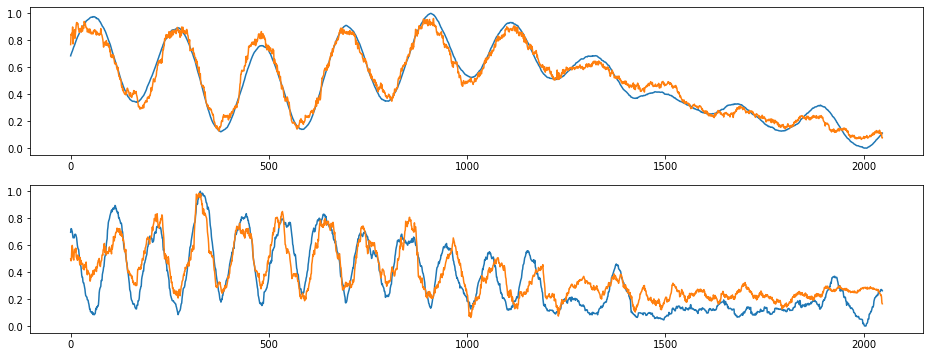

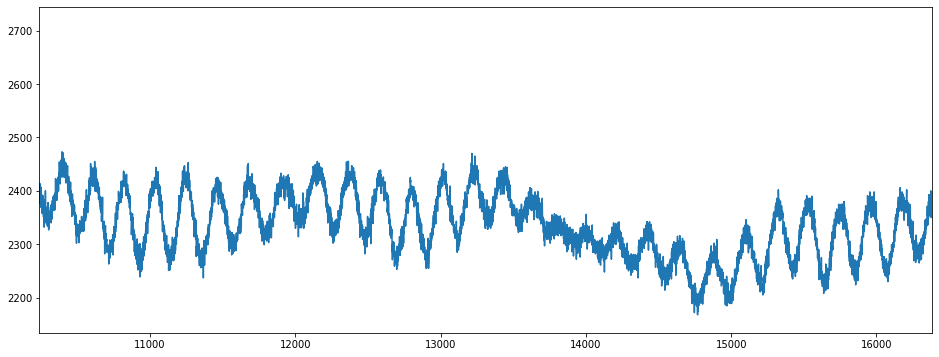

index:  24516
MAE:  0.07291808207669187
n_bunches       2556
bunch_index     2049
bunch_number    1499
chunk             12
Name: 3165, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6759/instability_data/06759_Inst_B1H_Q7_20180605_01h53m14s.h5


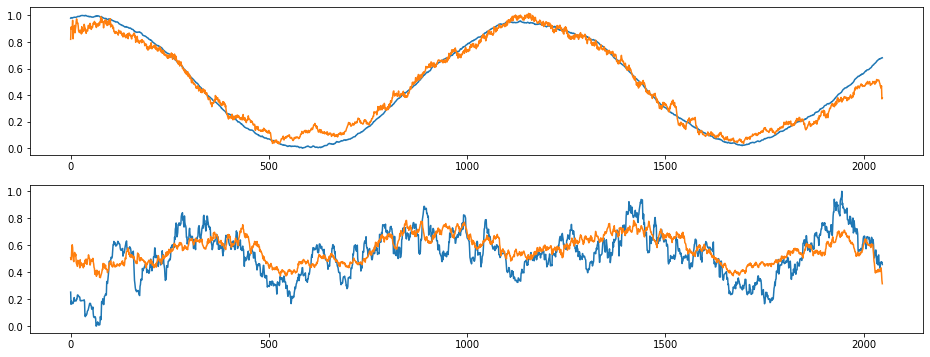

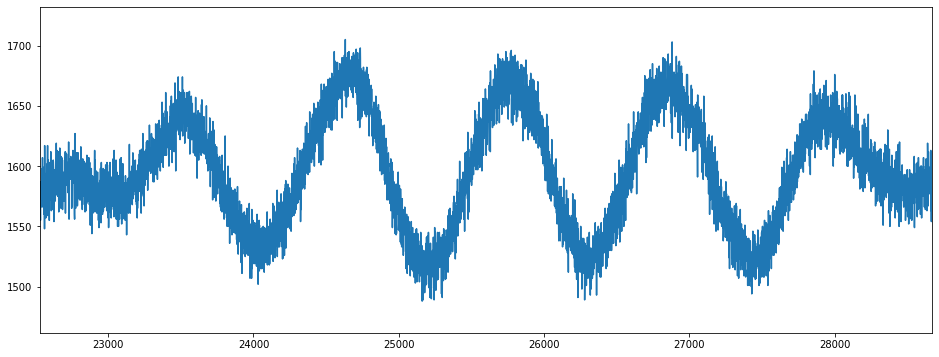

index:  258998
MAE:  0.07291809262401436
n_bunches       108
bunch_index      45
bunch_number      8
chunk             0
Name: 14, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6740/instability_data/06740_Inst_B1H_Q7_20180530_07h16m51s.h5


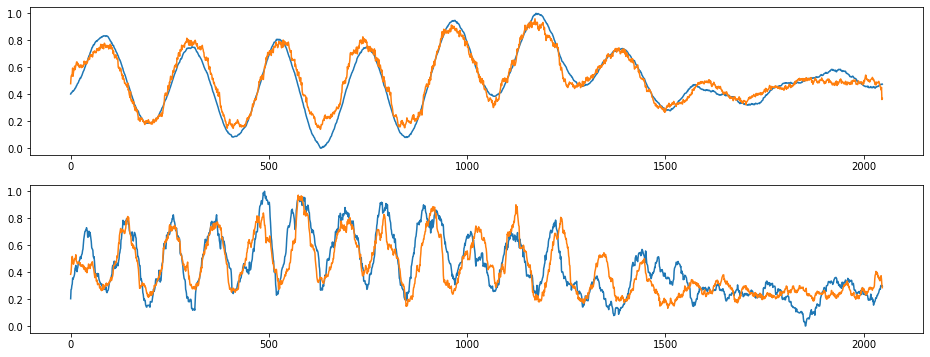

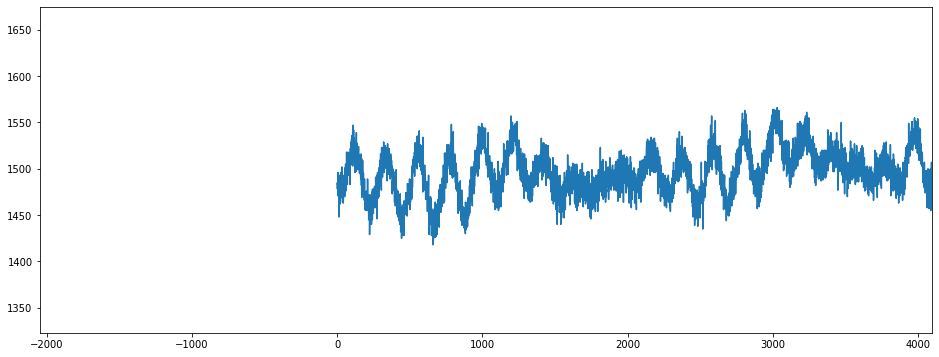

index:  174951
MAE:  0.07291814746574665
n_bunches       636
bunch_index     118
bunch_number     62
chunk            20
Name: 5240, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7325/instability_data/07325_Inst_B1H_Q7_20181021_19h00m42s.h5


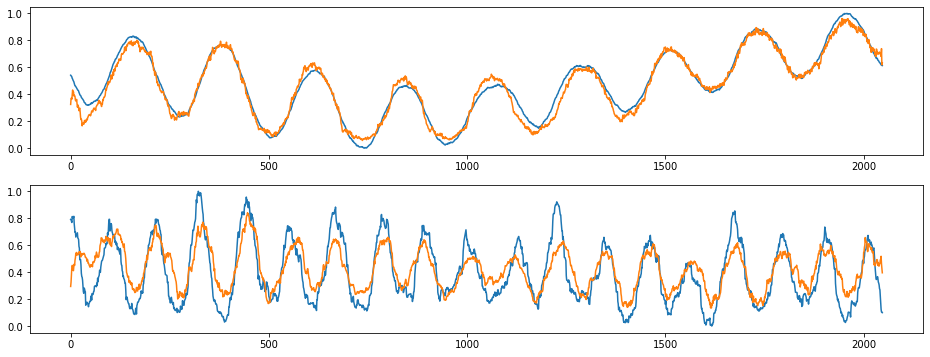

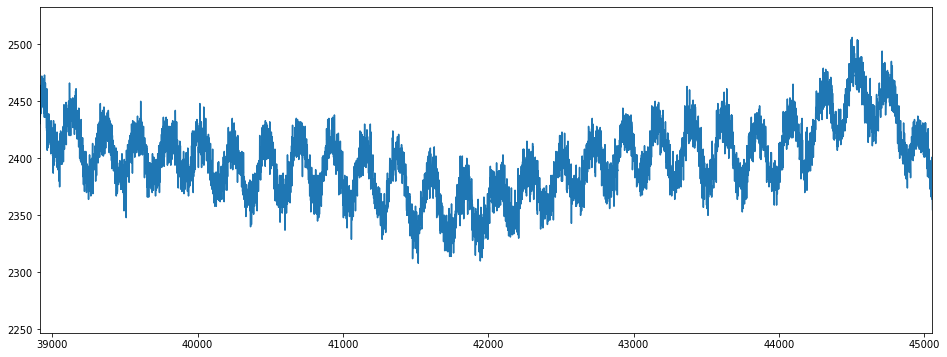

index:  32822
MAE:  0.07291821034649512
n_bunches       686
bunch_index     624
bunch_number    118
chunk            21
Name: 5482, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6238/instability_data/06238_Inst_B1H_Q7_20170923_22h21m23s.h5


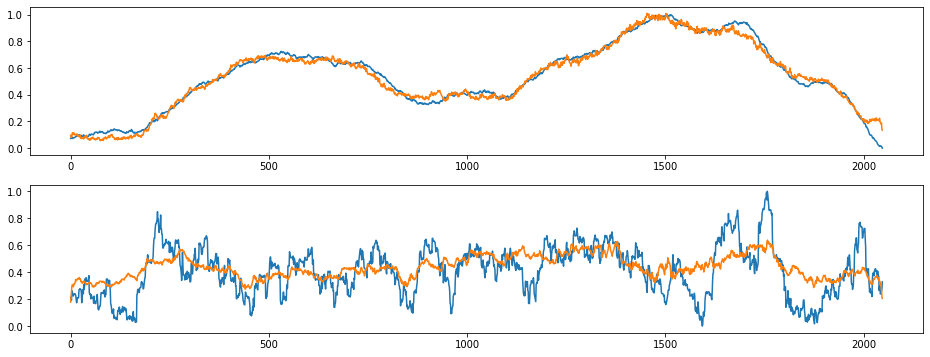

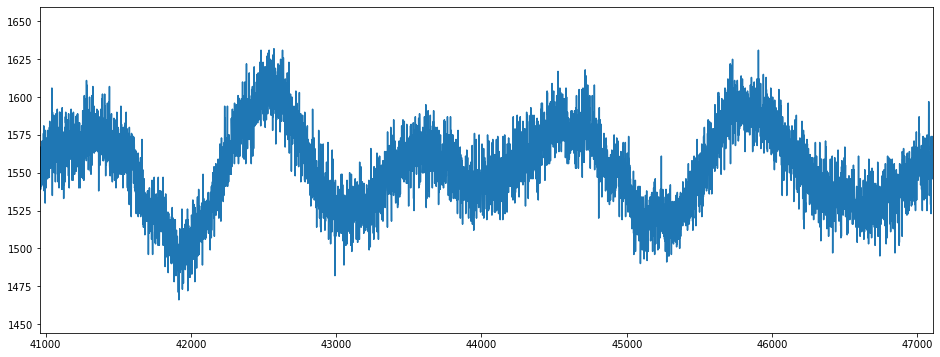

index:  318316
MAE:  0.07291826899708492
n_bunches       156
bunch_index     209
bunch_number    140
chunk             8
Name: 2126, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/instability_data/06639_Inst_B1H_Q7_20180503_15h29m14s.h5


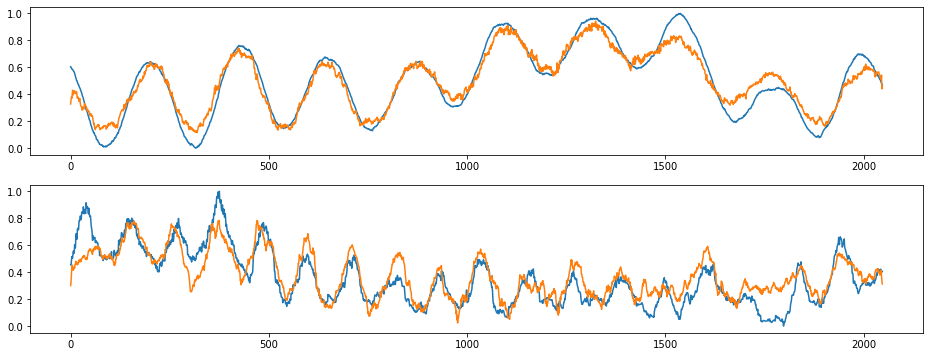

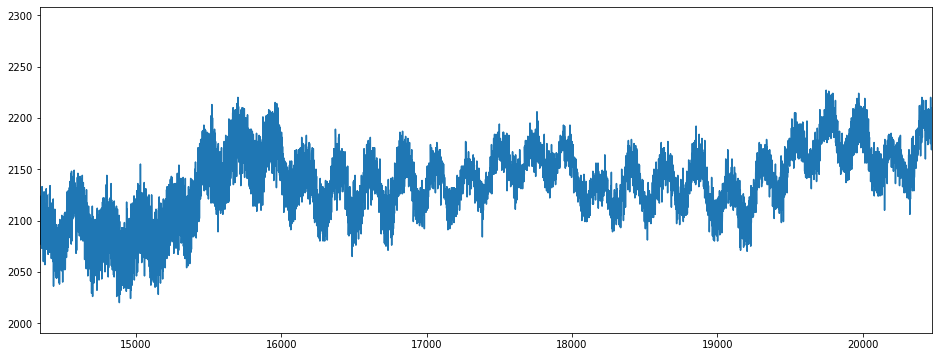

index:  325850
MAE:  0.07291830795386725
n_bunches       648
bunch_index     893
bunch_number    166
chunk             1
Name: 483, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_08h33m16s.h5


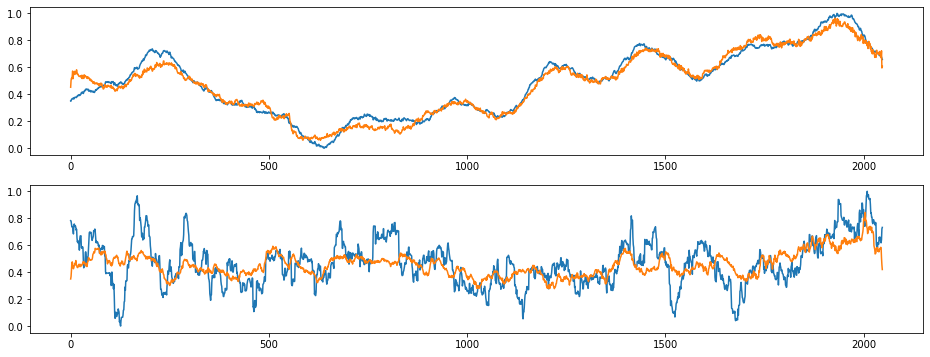

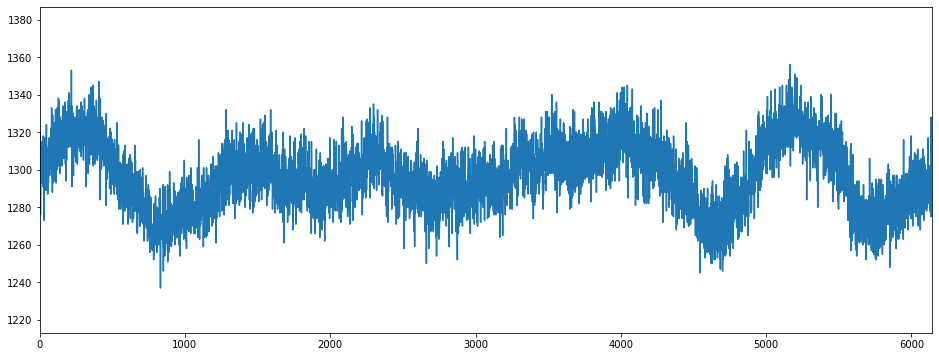

index:  295681
MAE:  0.07291831890539252
n_bunches       108
bunch_index     445
bunch_number     78
chunk            16
Name: 4104, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7449/instability_data/07449_Inst_B1H_Q7_20181116_17h13m28s.h5


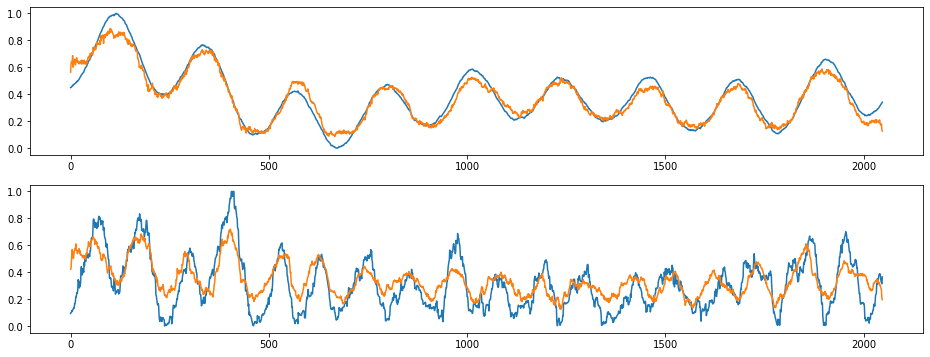

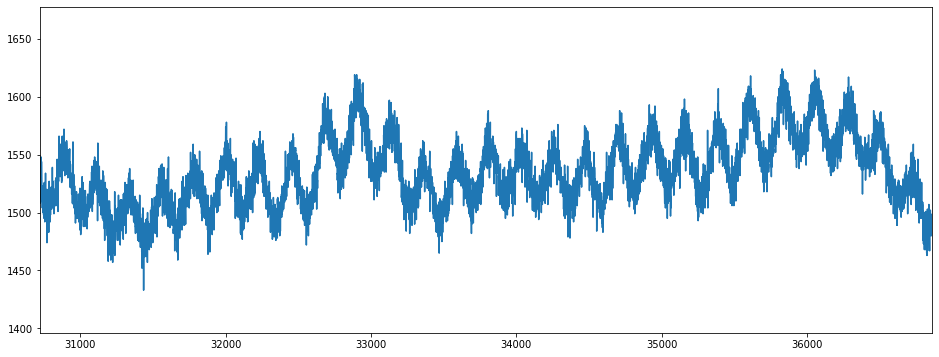

In [33]:
for i in range(10):
    anomalous_index = around_peak_indices[i]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# around a point

In [57]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.182))

index:  321287
MAE:  0.18197926496572323
n_bunches        780
bunch_index     1399
bunch_number     760
chunk              5
Name: 1303, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6415/instability_data/06415_Inst_B1H_Q7_20171125_04h18m24s.h5


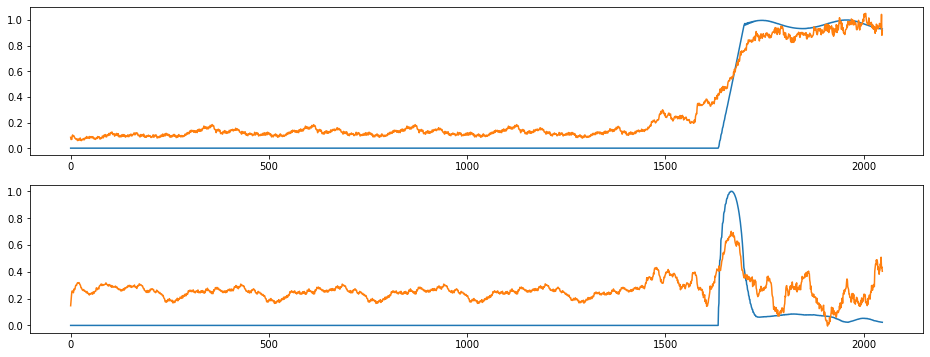

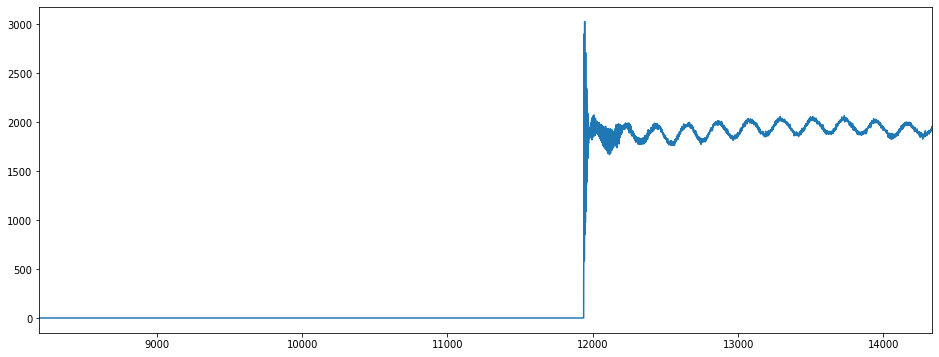

index:  284863
MAE:  0.1817611423487774
n_bunches       108
bunch_index     142
bunch_number     86
chunk            11
Name: 2841, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7109/instability_data/07109_Inst_B1H_Q7_20180831_19h38m30s.h5


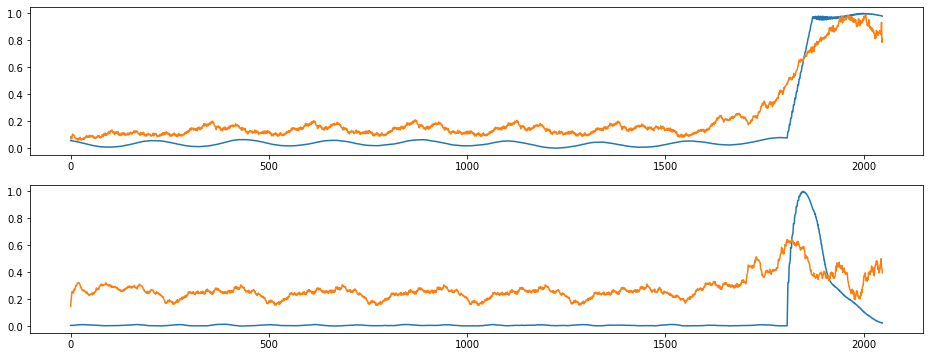

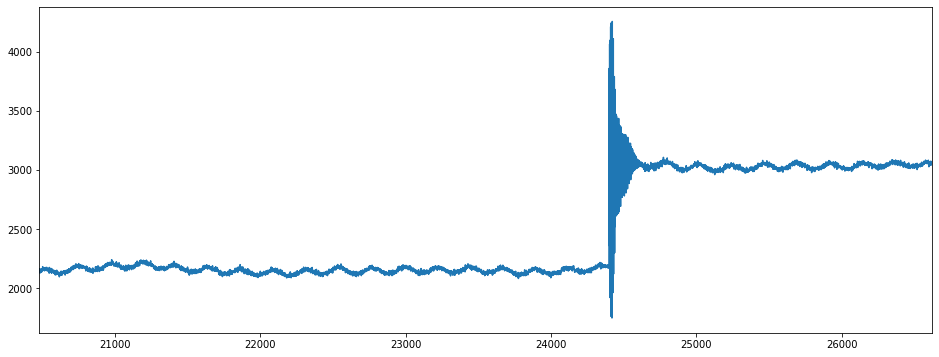

index:  49178
MAE:  0.18170146331813591
n_bunches       300
bunch_index     353
bunch_number    177
chunk             5
Name: 1342, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_06h41m44s.h5


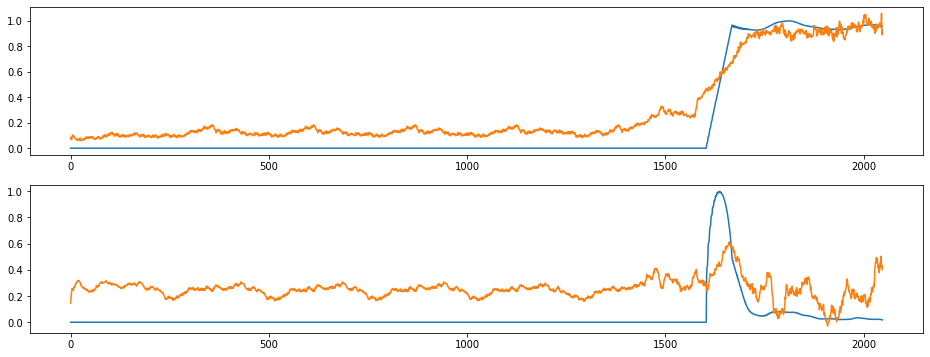

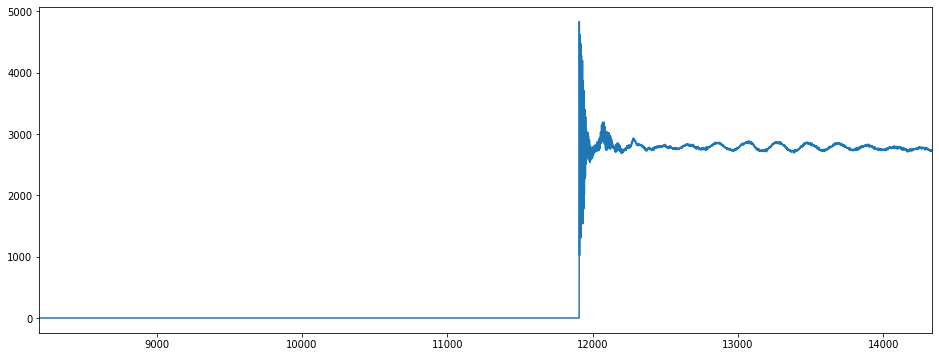

index:  346868
MAE:  0.18274952173916392
n_bunches       156
bunch_index     336
bunch_number    148
chunk            12
Name: 3234, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7350/instability_data/07350_Inst_B1H_Q7_20181025_15h14m45s.h5


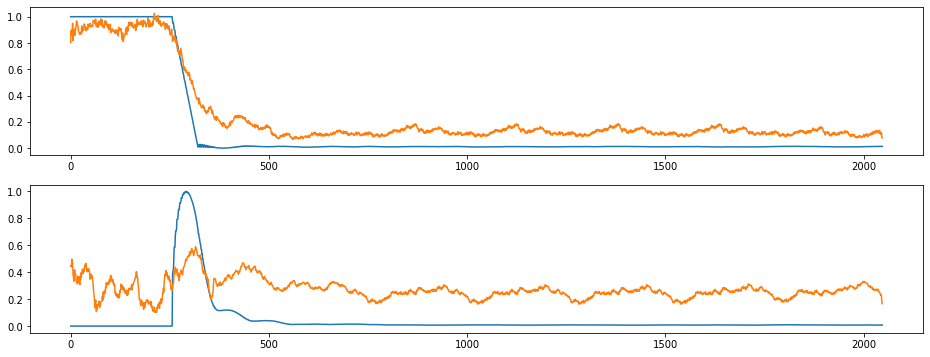

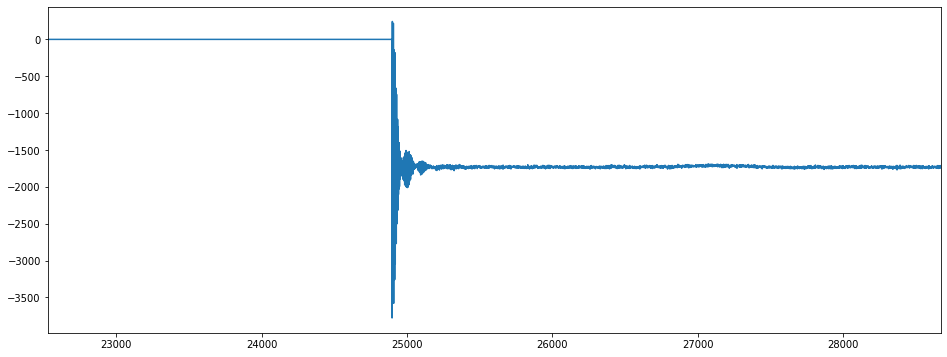

index:  343032
MAE:  0.1829942001195377
n_bunches       156
bunch_index     336
bunch_number    148
chunk            11
Name: 2978, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7350/instability_data/07350_Inst_B1H_Q7_20181025_15h14m45s.h5


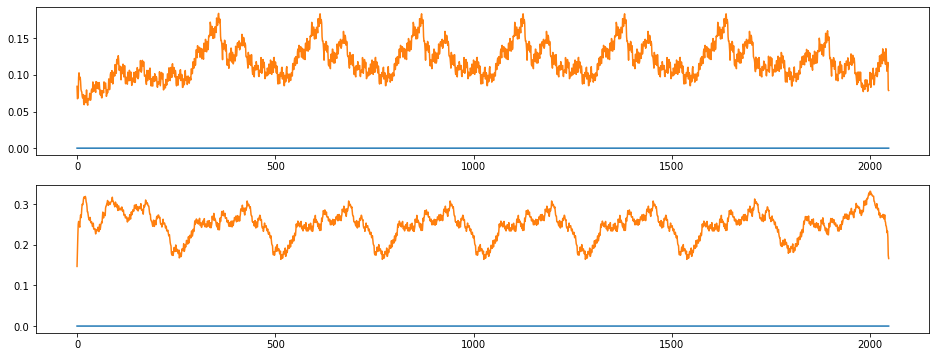

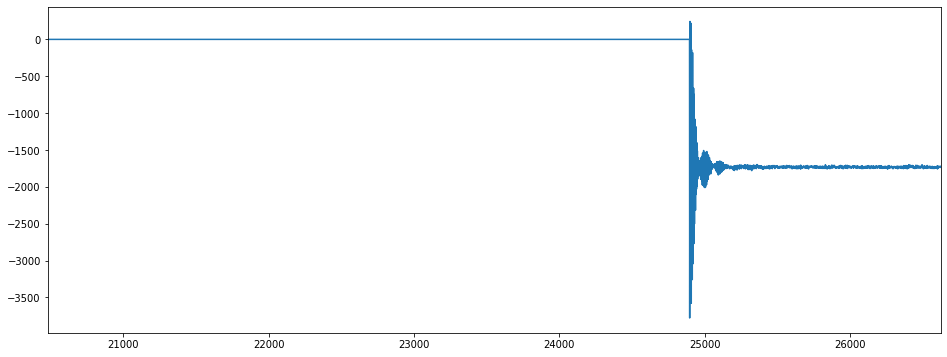

index:  323068
MAE:  0.1829942001195377
n_bunches        420
bunch_index     1717
bunch_number     323
chunk              5
Name: 1526, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7058/instability_data/07058_Inst_B1H_Q7_20180817_05h32m15s.h5


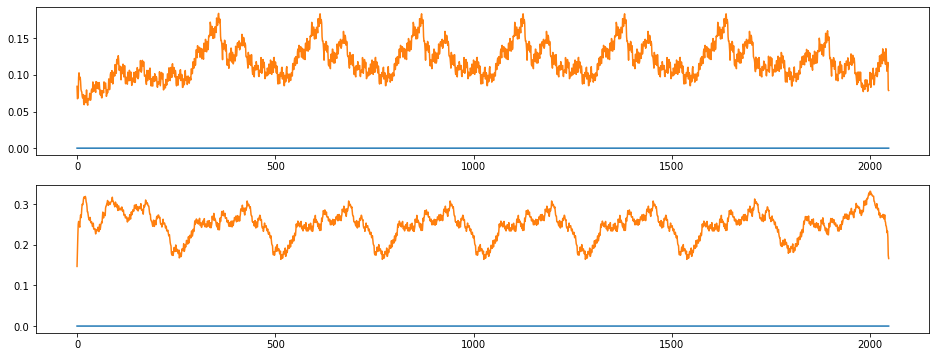

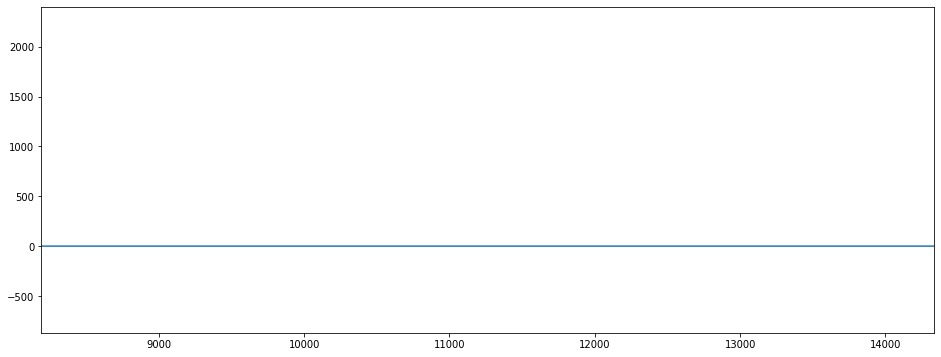

index:  320316
MAE:  0.1829942001195377
n_bunches        420
bunch_index     1717
bunch_number     323
chunk             16
Name: 4342, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7058/instability_data/07058_Inst_B1H_Q7_20180817_05h32m15s.h5


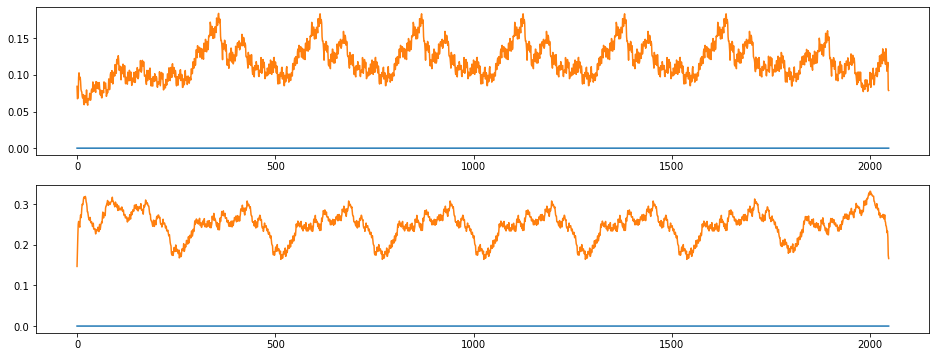

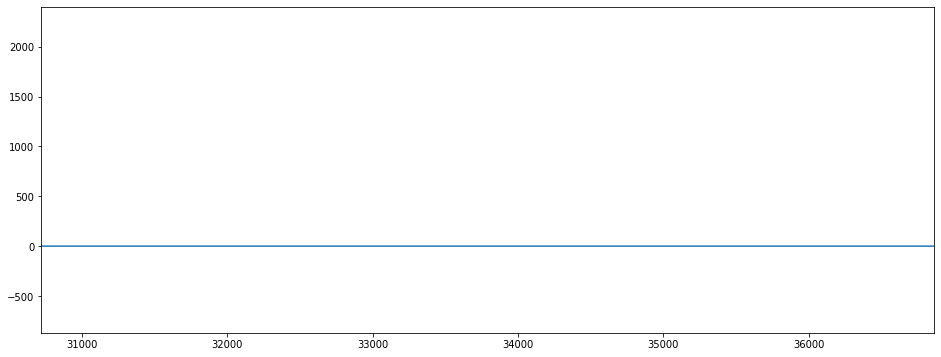

index:  175344
MAE:  0.1829942001195377
n_bunches       396
bunch_index     861
bunch_number    353
chunk             5
Name: 1325, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6398/instability_data/06398_Inst_B1H_Q7_20171119_21h06m25s.h5


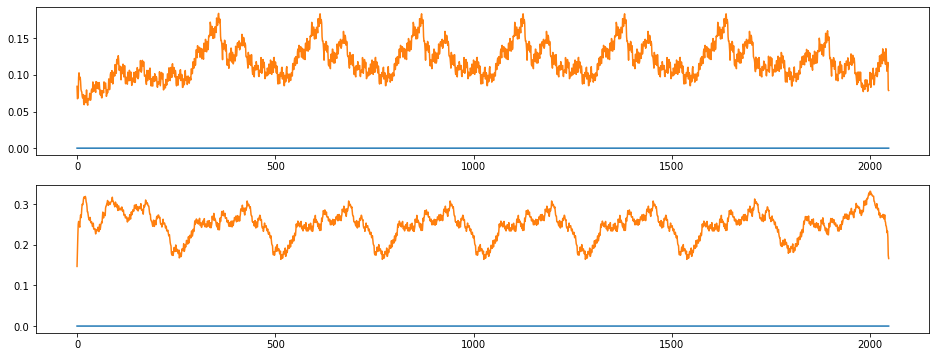

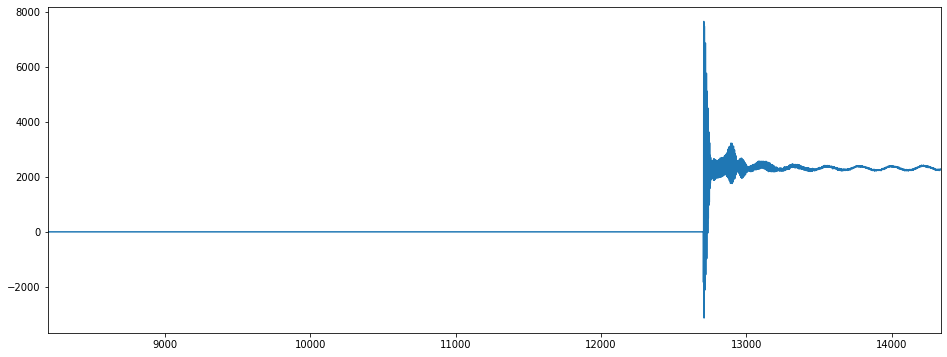

index:  232481
MAE:  0.1829942001195377
n_bunches        780
bunch_index     1423
bunch_number     776
chunk              3
Name: 896, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6351/instability_data/06351_Inst_B1H_Q7_20171031_15h16m08s.h5


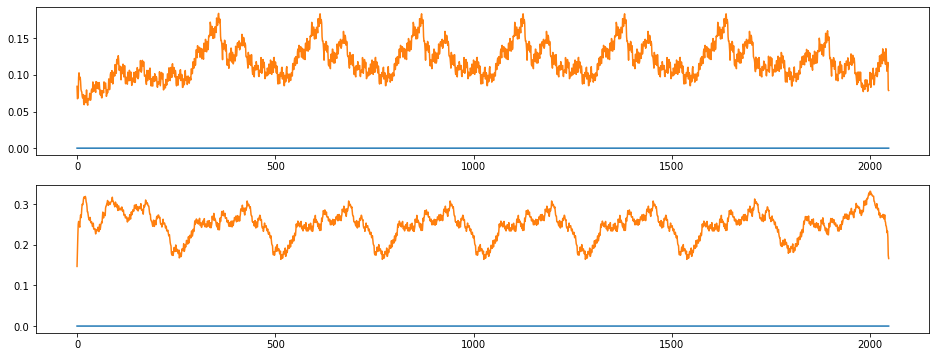

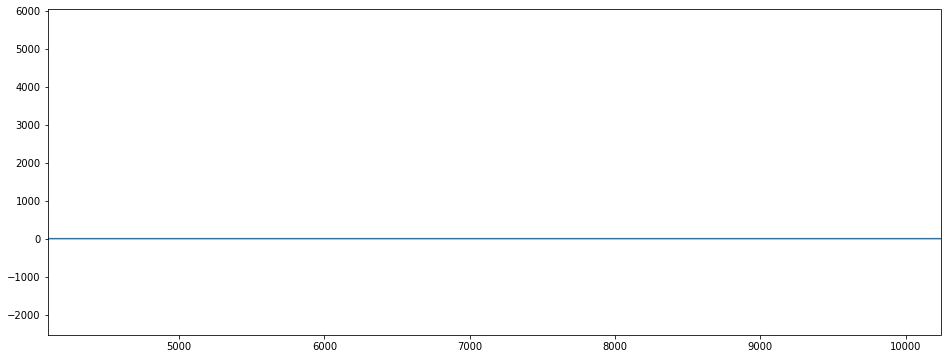

index:  245747
MAE:  0.1829942001195377
n_bunches       108
bunch_index     120
bunch_number     64
chunk             9
Name: 2384, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7252/instability_data/07252_Inst_B1H_Q7_20181003_02h02m48s.h5


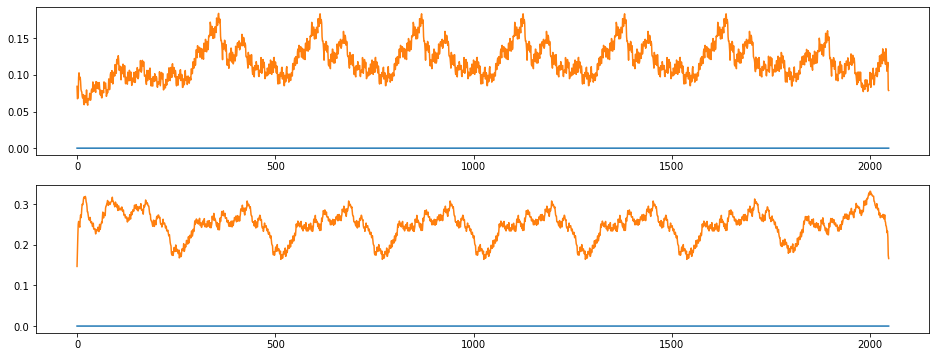

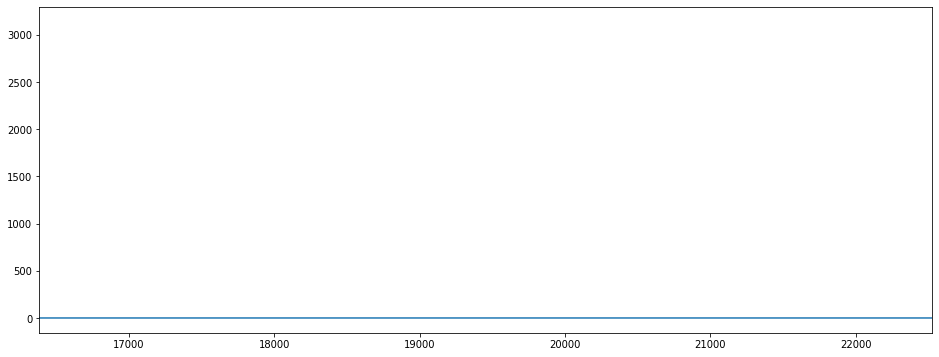

In [58]:
for i in range(10):
    index = around_point_indices[i]

    print('index: ', index)
    print("MAE: ", MAE_train[index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[index].squeeze()
    pred_signal = train_pred[index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

In [36]:
break

SyntaxError: 'break' outside loop (<ipython-input-36-6aaf1f276005>, line 4)

# latent space encoding

In [ ]:
import keras

In [ ]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [ ]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

In [ ]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

In [ ]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

In [ ]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [ ]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [ ]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [ ]:
np.save(model_latent_space_file, latent_dataset)

In [ ]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [ ]:
np.save(model_train_dataset_file, train_dataset)

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)